# Date Fruit Dataset - Analysis and Model Training
This dataset comes from a paper (reference below) which extracted features from 898 images of 7 different Date species in an effort ot classify them using Logistic Regression and Artificial Neural Networks, which yielded classification accuracies of 91.0% and 92.2%, respectively. Stacking the models yielded a slight increase in accuracy (92.8%).

The authors don't mention any feature selection strategies or attempts to further improve their models. Since feature selection, feature transformation, model selection, and hyperparameter tuning can optimize performance, I am curious to see if better accuracies can be achieved on this dataset.

KOKLU, M., KURSUN, R., TASPINAR, Y. S., and CINAR, I. (2021). Classification of Date Fruits into Genetic Varieties Using Image Analysis. Mathematical Problems in Engineering, Vol.2021, Article ID: 4793293, DOI:10.1155/2021/4793293
https://www.hindawi.com/journals/mpe/2021/4793293/
DATASET: https://www.muratkoklu.com/datasets/
https://www.kaggle.com/mkoklu42

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sa
import statsmodels.formula.api as sfa
from scikit_posthocs import posthoc_mannwhitney
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("Date_Fruit_Datasets/raw_dataset.xlsx")
df.rename(columns={'Class':'Species'}, inplace=True)
df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,Species
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400,BERHI
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315,BERHI
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378,BERHI
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882,BERHI
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666,BERHI


## Exploratory Data Analysis - Feature Selection
Before making any predictions, we need to explore the data and look for patterns which will us predict the Date species

In [2]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
nclasses = y.nunique()
nfeatures = len(X.columns)

print(f"{nclasses} Species, {nfeatures} features")
print(df["Species"].value_counts())

7 Species, 34 features
DOKOL     204
SAFAVI    199
ROTANA    166
DEGLET     98
SOGAY      94
IRAQI      72
BERHI      65
Name: Species, dtype: int64


Two things jump out with this quick summary:
1. The dataset is imbalanced
2. There are at least 2 observations per feature per class, far fewer than the desired value of 10

Taking these observations into account will help us better train our models.

In [3]:
sig_features = []

for col in X.columns:
    # fit linear model with each feature
    lm = sfa.ols(f"{col} ~ C(Species)", data=df).fit()
    # run ANOVA
    anova = sa.stats.anova_lm(lm)
    # get ANOVA p value
    pval = anova["PR(>F)"]["C(Species)"]
    if pval < 1e-10:
        sig_features.append(col)
        
print(len(sig_features))

32


ANOVA helped us remove two variables which were not different at all between the species. Since all features came from images of Dates taken under similar conditions, it is quite likely that some features are correlated with each other.

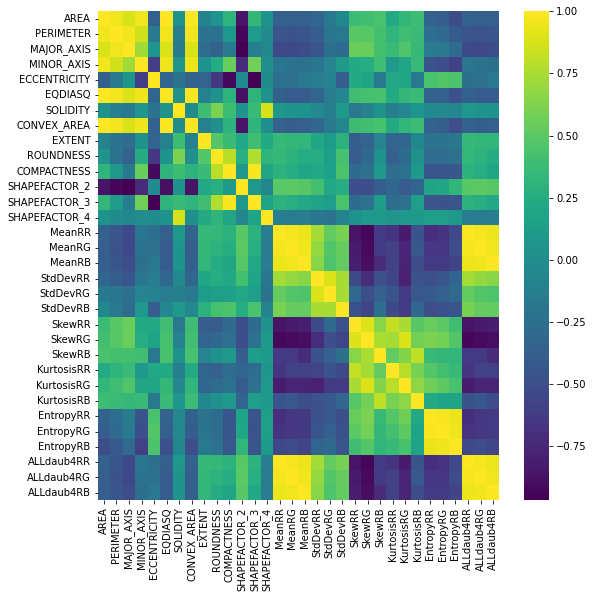

In [4]:
X = df[sig_features].copy()
plt.figure(figsize=(9, 9))
ax = sns.heatmap(X.corr(), cmap="viridis")

Areas of navy and yellow indicate high correlation and represent features we may wish to drop. Let's get the columns with shared correlation greater than 0.7, examine which of these contributes the most significant difference between the Date `Species`, and remove the other correlated features. How many features do you think will be left over?

In [5]:
print(f"{X.shape[1]} features")

corr = X.corr()
for col in X.columns:
    # col might have been removed by a previous iteration
    if col in X.columns:
        corrs = np.abs(corr[col]) > 0.7
        mwu_vals = []
        # has to be greater than 1 since the column itself is included
        if corrs.sum() > 1:
            # get list of correlated columns
            corr_cols = list(corrs[corrs == 1].index)
            for c in corr_cols:
                # calculate Tukey p values for each Species
                mwu = posthoc_mannwhitney(df, val_col=c, group_col="Species", p_adjust="bonferroni").to_numpy()
                # mask significant p values
                mask = mwu < 1e-10
                # only account for significant differences in sum
                res = (mask * mwu).sum()
                mwu_vals.append(res)
            # find index of total lowest p values and remove from corr_cols
            # so that we can keep this column for further use
            keep_idx = np.argmin(mwu_vals)
            del corr_cols[keep_idx]
            # drop remaining correlated columns
            X.drop(columns=corr_cols, inplace=True)
            corr = X.corr()

print(f"{X.shape[1]} features")

32 features
9 features


Excellent! We've gone from 32 down to 9 features which have far lower correlation. Let's have a quick peak at the correlation heatmap to see how it looks

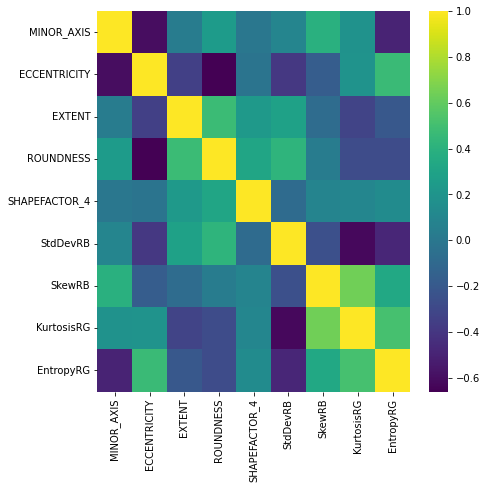

In [6]:
plt.figure(figsize=(7, 7))
ax = sns.heatmap(X.corr(), cmap="viridis")

In [7]:
# Save the reduced features dataset for later training
data = pd.concat([X, y], axis=1)
data.to_excel("Date_Fruit_Datasets/reduced_features_dataset.xlsx", index=False)

## Exploratory Data Analysis - Transformation and Scaling
Linear models such as Logistic Regression can be impacted by features with drastically different ranges and non-normal distributions. To compensate for this, we can apply mathematical transformations to compress or transform our features into specific ranges. To see if this is necessary, let's look at the distribution and scale of each feature.

In [8]:
X.describe()

,MINOR_AXIS,ECCENTRICITY,EXTENT,ROUNDNESS,SHAPEFACTOR_4,StdDevRB,SkewRB,KurtosisRG,EntropyRG
count,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,898.000000,8.980000e+02
mean,495.872785,0.737468,0.736267,0.857720,0.988680,26.148330,0.250518,5.110894,-2.901860e+10
std,114.268917,0.088727,0.053745,0.070839,0.020473,4.905078,0.632918,3.745463,1.712952e+10
min,2.283200,0.344800,0.512300,0.004800,0.756800,5.148600,-1.029100,1.607600,-9.261697e+10
25%,404.684375,0.685625,0.705875,0.827750,0.989300,22.890975,-0.196950,2.508850,-3.894638e+10
50%,495.054850,0.754700,0.746950,0.867750,0.993600,26.469000,0.135550,3.127800,-2.620990e+10
75%,589.031700,0.802150,0.775850,0.899500,0.996400,29.482375,0.593950,7.320400,-1.433105e+10
max,766.453600,1.000000,0.856200,0.977300,0.999500,42.422800,3.092300,26.736700,-5.627727e+08


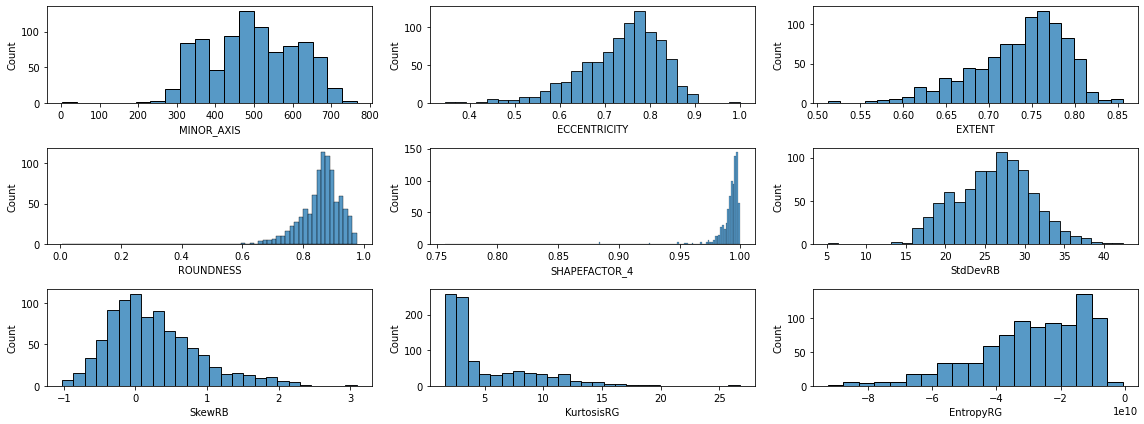

In [9]:
def histograms(data):
    plt.figure(figsize=(16, 6))
    for i, col in enumerate(data.columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data[col])
    plt.tight_layout()
    
histograms(X)

These histograms show us some extreme outliers exist in the data, which we may want to remove. For example, a `MINOR_AXIS` measurement between 0-50 indicate a very thin Date, which seems erroneous so we can drop that observation.

These features have drastically different ranges and some will need to be transformed to remove the skew in their distributions. Let's look at the Q-Q plots to see just how non-normal these data are.

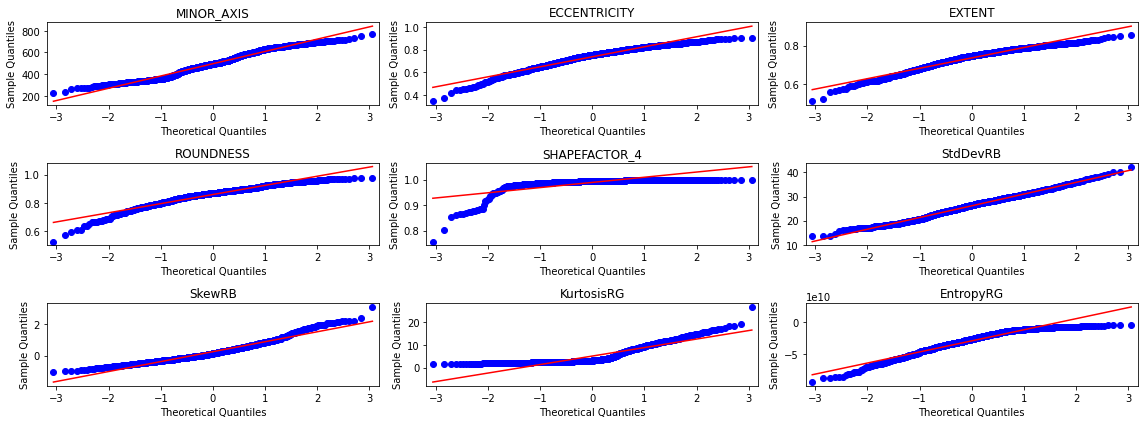

In [10]:
X = X[X["MINOR_AXIS"] > 50]

def qqplots(dataframe, transform=None):
    fig, axes = plt.subplots(3, 3, figsize=(16, 6))
    for i, col in enumerate(dataframe.columns):
        a = i // 3
        b = i % 3
        if transform == None:
            data = dataframe[col]
        else:
            try:
                data = dataframe[col].apply(lambda x: transform(x))
            except TypeError:
                data = dataframe[col]
        qqplot(data, line="s", ax=axes[a, b])
        axes[a, b].set_title(col)
    plt.tight_layout()
    
qqplots(X)

* `MINOR_AXIS` and `StdDevRB` appear normal so we can don't need to apply any transformations to these data
* Using the `transform` lambda function, we can test a variety of different transformations to see which is appropriate for each variable

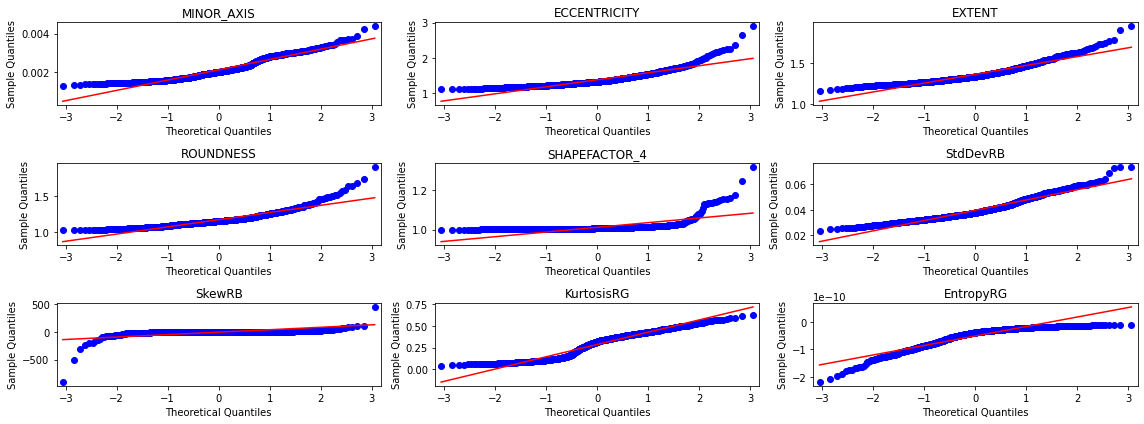

In [11]:
transform = lambda x: 1 / x
dropped = X[X["MINOR_AXIS"] > 100]
qqplots(dropped, transform)

Playing around with these graphs, we see that the data become normal with the following transformations:
* $ ROUNDNESS^5 $
* $ ECCENTRICITY^3 $
* $ {EXTENT}^3 $
* $ ln(SkewRB + 2) $
* $ |EntropyRG|^{0.25} $
* $ \frac{1}{ln(KurtosisRG)} $

(best I can do to minimize the tail in `KurtosisRG`)
* $ SHAPEFACTOR_4 $ 

(nothing I could do to normalize `SHAPEFACTOR_4`)

Attempts to transform SHAPEFACTOR_4 were unsuccessful since the majority of the values are close to 1. It may also be the case that the values far from 1 belong to a specific class, thus their deviation from 1 may be important for predicting classes.

<AxesSubplot:xlabel='Species', ylabel='SHAPEFACTOR_4'>

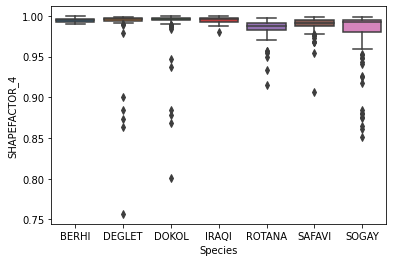

In [12]:
sns.boxplot(x="Species", y="SHAPEFACTOR_4", data=df)

The boxplots show that `SHAPEFACTOR_4` has a number of outliers for most classes. Therefore, this feature doesn't really contribute to separation of our classes, so let's drop it. 

In [13]:
X["ROUNDNESS"] = np.power(X["ROUNDNESS"], 5)
X["ECCENTRICITY"] = np.power(X["ECCENTRICITY"], 3)
X["EXTENT"] = np.power(X["EXTENT"], 3)
X["SkewRB"] = np.log(X["SkewRB"] + 2)
X["KurtosisRG"] = 1 / np.log(X["KurtosisRG"])
X["EntropyRG"] = np.abs(X["EntropyRG"]) ** 0.25

Now that the variables have been transformed to better approximate a normal distribution, we can scale the data to the same range and save it for training.

In [14]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
transformed = pd.DataFrame(scaled, columns=X.columns)
transformed["Species"] = df["Species"]
transformed.drop(columns=["SHAPEFACTOR_4"], inplace=True)
transformed.to_excel("Date_Fruit_Datasets/scaled_reduced_dataset.xlsx", index=False)